In [7]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS, FeatureHasher
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans

from matplotlib import pyplot as plt
import seaborn as sns

## Sentiment

In [8]:
from textblob import TextBlob

In [9]:
#import scripts broken down in to dialog chunks
df = pd.read_csv('tng_scripts.csv', index_col=0)
df.shape

(174, 5)

In [14]:
#polarity -1 to 1 
#subjectivity 0 to 1 (1 = most subjective)
txt = str(df.script.sample(1))

blob = TextBlob(txt)
print("Sentence:")
print(txt)
print(f"Valence {blob.sentiment}")

Sentence:
85    \n\n\n\n                STAR TREK: THE NEXT GE...
Name: script, dtype: object
Valence Sentiment(polarity=0.0, subjectivity=0.0)


In [18]:
def get_polarity(t):
    blob = TextBlob(t)
    return blob.sentiment[0]

df['polarity'] = df.script.apply(get_polarity)

In [19]:
def get_subjectivity(t):
    blob = TextBlob(t)
    return blob.sentiment[1]

df['subjectivity'] = df.script.apply(get_subjectivity)

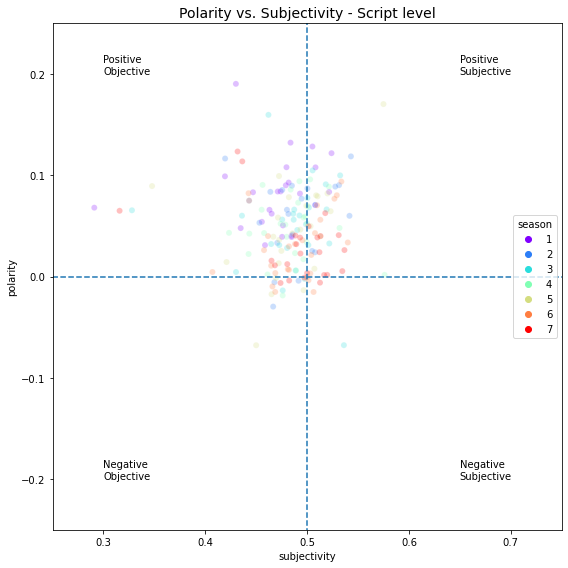

In [22]:
plt.figure(figsize=(8,8))

sns.scatterplot(data=df, x='subjectivity', y='polarity', hue='season',
               alpha = 0.25, palette='rainbow')
plt.hlines(y=0, xmin=0, xmax=1, linestyles='--')
plt.vlines(x=0.5, ymin=-1, ymax=1, linestyles='--')

plt.annotate("Positive \nObjective", xy = (0.3, 0.2))
plt.annotate("Positive \nSubjective", xy = (0.65, 0.2))
plt.annotate("Negative \nObjective", xy = (0.3, -0.2))
plt.annotate("Negative \nSubjective", xy = (0.65, -0.2))

plt.title('Polarity vs. Subjectivity - Script level', fontdict={'fontsize':14})

plt.xlim((0.25,0.75))
plt.ylim((-0.25, 0.25))

plt.legend(title='season', loc='center right')
plt.tight_layout()
plt.savefig('graphics/polarity_vs_sentiment_SCRIPT.png');

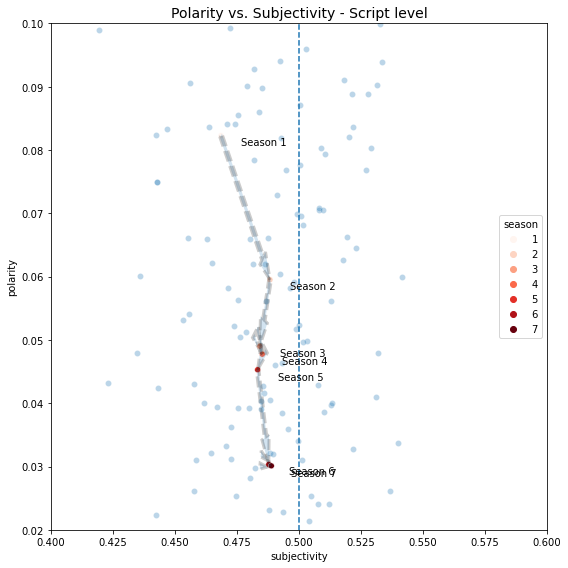

<Figure size 432x288 with 0 Axes>

In [31]:
plt.figure(figsize=(8,8))

sns.scatterplot(data=df, x='subjectivity', y='polarity',
               alpha = 0.3, palette='rainbow')
plt.hlines(y=0, xmin=0, xmax=1, linestyles='--')
plt.vlines(x=0.5, ymin=-1, ymax=1, linestyles='--')

plt.annotate("Positive \nObjective", xy = (0.3, 0.2))
plt.annotate("Positive \nSubjective", xy = (0.65, 0.2))
plt.annotate("Negative \nObjective", xy = (0.3, -0.2))
plt.annotate("Negative \nSubjective", xy = (0.65, -0.2))

plt.title('Polarity vs. Subjectivity - Script level', fontdict={'fontsize':14})

plt.xlim((0.4,0.6))
plt.ylim((0.02, 0.1))


df_group = df.groupby('season').agg({'subjectivity':np.mean,
                                     'polarity':np.mean})

x = df_group['subjectivity'][1]
y = df_group['polarity'][1]
#plt.scatter(x=x, y=y, marker='*')
sns.scatterplot(x=df_group['subjectivity'], y=df_group['polarity'],
            markers=True, hue=df_group.index, palette='Reds', )

plt.annotate('Season 1', xy = (x,y),
            xytext=(20, -10), textcoords='offset pixels')

for row in range(2,8):
    new_x = df_group['subjectivity'][row]
    new_y = df_group['polarity'][row]
    plt.arrow(x=x, y=y, dx=new_x-x, dy=new_y-y, alpha=0.2,
              linewidth=3, linestyle="--", length_includes_head=True )
    plt.annotate(f'Season {row}', xy = (new_x,new_y),
                xytext=(20, -10), textcoords='offset pixels')
    x = new_x
    y = new_y


plt.legend(title='season', loc='center right')
plt.tight_layout()
plt.show()

plt.savefig('graphics/polarity_vs_sentiment_alt.png');

## Reading Scores

In [36]:
from textatistic import Textatistic


In [40]:
ll = []

for i, row in df.iterrows():
    readability_scores = Textatistic(row.script).scores
    readability_scores['ep'] = row.episode
    readability_scores['season'] = row.season
    ll.append(readability_scores)
    
df_temp = [pd.DataFrame(i, index = [0]) for i in ll]

df_read = pd.concat(df_temp)

df_read.reset_index(drop=True, inplace=True )

df_read.head()

,flesch_score,fleschkincaid_score,gunningfog_score,smog_score,dalechall_score,ep,season
0,83.142010,3.561482,6.262283,7.599711,8.553758,102,1
1,85.851218,2.895535,5.541964,7.078451,8.598176,103,1
2,85.618933,3.073602,5.609676,7.134795,8.546280,104,1
3,77.079593,4.813683,7.418897,8.426883,10.732672,105,1
4,85.795305,2.697269,5.457581,6.968800,8.144021,106,1


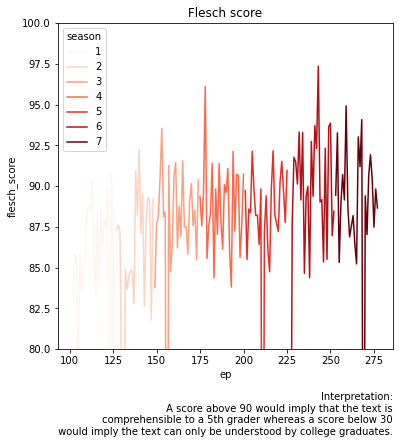

In [48]:
plt.figure(figsize=(6,6))
plt.title('Flesch score')
sns.lineplot(data=df_read, x='ep', y='flesch_score', hue='season', palette='Reds')

plt.annotate('Interpretation:\n A score above 90 would imply that the text is\n comprehensible to a 5th grader whereas a score below 30\n would imply the text can only be understood by college graduates.', 
              xy = (1.0, -0.2),
              xycoords='axes fraction',
              ha='right',
              va="center", 
              fontsize=10)
plt.ylim((80,100))
plt.savefig('graphics/fleshscore.png');

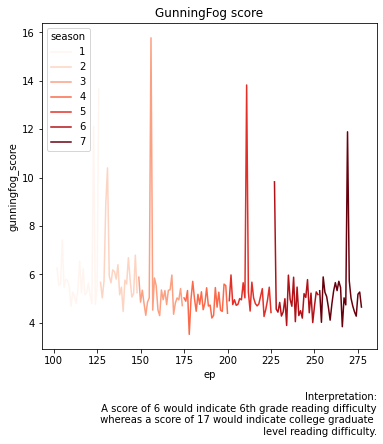

In [49]:
plt.figure(figsize=(6,6))
plt.title('GunningFog score')
sns.lineplot(data=df_read, x='ep', y='gunningfog_score', hue='season', palette='Reds')

(plt.annotate('Interpretation:\n A score of 6 would indicate 6th grade reading difficulty\n whereas a score of 17 would indicate college graduate \n level reading difficulty.', 
              xy = (1.0, -0.2),
              xycoords='axes fraction',
              ha='right',
              va="center", 
              fontsize=10))
plt.savefig('graphics/gunningfogscore.png')